### Import all packages

In [1]:
# from hw2
import pydub
from pydub import AudioSegment
import pydub
from pydub.playback import play
from python_speech_features import mfcc
from python_speech_features import logfbank
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from time import sleep
import scipy.io.wavfile as wav
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import torch

### Preparing the dataset

In [3]:
downloaded_files = glob(f"./data/audios/*.mp3")
num_downloaded_files = len(downloaded_files)

In [4]:
dev = pd.read_csv("./data/tsvs/dev.tsv", sep="\t")
train = pd.read_csv("./data/tsvs/train.tsv", sep="\t")
test = pd.read_csv("./data/tsvs/test.tsv", sep="\t")
validated = pd.read_csv("./data/tsvs/validated.tsv", sep="\t")
invalidated = pd.read_csv("./data/tsvs/invalidated.tsv", sep="\t")

splits = {
    "dev": dev,
    "train": train, 
    "test": test,
    "validated": validated,
    "invalidated": invalidated
}

#### Fix the paths

In [5]:
prefix = "./data/audios/"
for key in splits:
    splits[key]['path'] = prefix + splits[key]['path'].astype(str)

#### Drop the rows with NaN accent values

In [6]:
for key in splits:
    print(len(splits[key]))

15531
232975
15531
218400
124820


In [7]:
for key in splits:
    splits[key].dropna(axis=0, subset=["accent"], inplace=True)
    print(len(splits[key]))

2100
135391
1398
46169
46728


#### Choose the data we've actually downloaded

In [8]:
for key in splits:
    splits[key] = splits[key][splits[key]["path"].isin(downloaded_files)]
    print(len(splits[key]))

2
414
2
41
76


#### Make sure speaker independent and validated

In [9]:
len(splits['train'][splits['train']["client_id"].isin(splits['test']['client_id'])])

0

In [10]:
len(splits['train'][splits['train']["client_id"].isin(splits['dev']['client_id'])])

0

In [11]:
num_train = len(splits['train'][splits['train']["client_id"].isin(splits['validated']['client_id'])])
num_test = len(splits['test'][splits['test']["client_id"].isin(splits['validated']['client_id'])])
num_dev = len(splits['dev'][splits['dev']["client_id"].isin(splits['validated']['client_id'])])

print(f"Wow, we only end up with {num_train} training, {num_test} test and {num_dev} dev audio files from the {num_downloaded_files} files we started with!")

Wow, we only end up with 37 training, 2 test and 2 dev audio files from the 900 files we started with!


#### For the purposes of this toy example we forgoe using only the validated clips and assume all clips are good. 

#### Lets take a look at some of our data

In [12]:
# visualize categorical data https://www.datacamp.com/community/tutorials/categorical-data
def visualize_categorical_distribution(pd_series, title="Plot", ylabel='Number of Samples', xlabel='Accent', figsize=None):
    digit_counts = pd_series.value_counts()
    sns.set(style="darkgrid")
    if figsize is None:
        sns.set(rc={'figure.figsize':(10,6)})
    else:
        sns.set(rc={'figure.figsize':figsize})
    sns.barplot(digit_counts.index, digit_counts.values, alpha=0.9)
    plt.title(title)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlabel(xlabel, fontsize=12)
    plt.show()

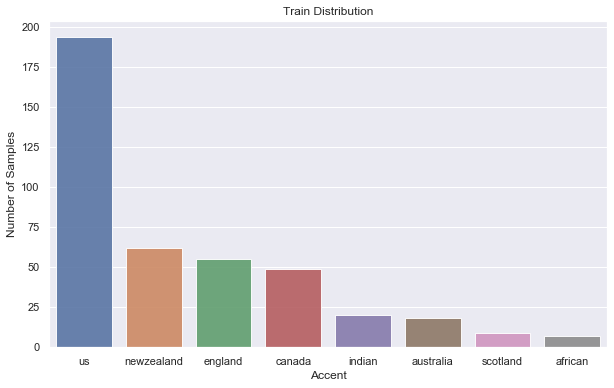

In [13]:
visualize_categorical_distribution(splits["train"]["accent"], "Train Distribution")

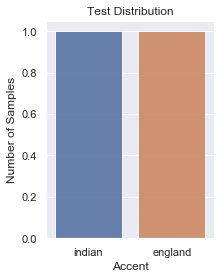

In [14]:
visualize_categorical_distribution(splits["test"]["accent"], "Test Distribution", figsize=(3,4))

# Yikes... That is a bad distribution.

Lets look at some other stuff...

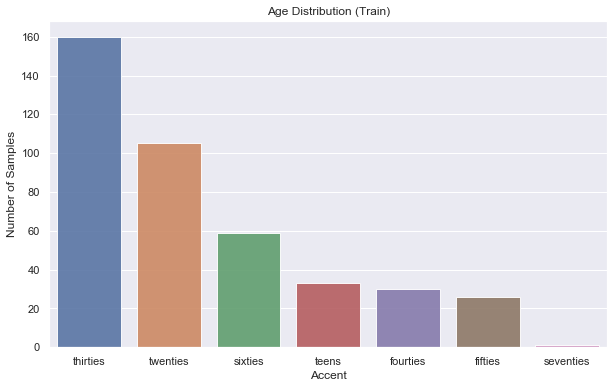

In [23]:
visualize_categorical_distribution(splits["train"]["age"], "Age Distribution (Train)")

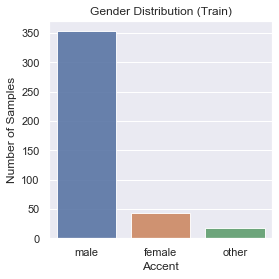

In [27]:
visualize_categorical_distribution(splits["train"]["gender"], "Gender Distribution (Train)", figsize=(4,4))

Lets play some audio files

In [29]:
def play_mp3_from_path(relative_path):
    """plays mp3 located at provided relative path, returns the audio segment"""
    a = pydub.AudioSegment.from_mp3(relative_path)
    # test that it sounds right (requires ffplay, or pyaudio):
    play(a)
    return a

In [32]:
# pick 4 random audio files from first 10
paths = np.random.choice(splits["train"]["path"][:10], size=4)

for path in paths:
    play_mp3_from_path(path)

#### Lets start preprocessing our actual audio files to the dataset

Some useful functions:

In [74]:
def read_mp3(f, normalized=False):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_mp3(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y

def write_mp3(f, sr, x, normalized=False):
    """numpy array to MP3"""
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
    song.export(f, format="mp3", bitrate="320k")

def detect_leading_silence(sound, silence_threshold=-50.0, chunk_size=10):
    '''
    sound is a pydub.AudioSegment
    silence_threshold in dB
    chunk_size in ms
    iterate over chunks until you find the first one with sound
    '''
    trim_ms = 0 # ms
    assert chunk_size > 0 # to avoid infinite loop
    while sound[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold and trim_ms < len(sound):
        trim_ms += chunk_size

    return trim_ms
def detect_leading_silence_filepath(filepath):
    sound = pydub.AudioSegment.from_mp3(filepath)
    return detect_leading_silence(sound)

def extract_mfcc(sound):
    chunk_size = 10
    first_noisy_idx = int(detect_leading_silence(sound, chunk_size=chunk_size))
    sound = sound[first_noisy_idx:]
    return mfcc(np.array(sound.get_array_of_samples()), samplerate=sound.frame_rate)
def extract_mfcc_filepath(filepath):
    sound = pydub.AudioSegment.from_mp3(filepath)
    return extract_mfcc(sound)


def extract_mfb(sound):
    chunk_size = 10
    first_noisy_idx = int(detect_leading_silence(sound, chunk_size=chunk_size))
    sound = sound[first_noisy_idx:]
    
    # make signal go back to array
    samples = np.array(sound.get_array_of_samples(), samplerate=sound.frame_rate) 
    if len(samples) == 0:
        raise Exception('Silent clip in extractMFB()')
    
    fbank_feat = logfbank(samples) #bam
    return fbank_feat
def extract_mfb_filepath(filepath):
    sound = pydub.AudioSegment.from_mp3(filepath)
    return extract_mfb(sound)

def length_of_file(filepath):
    sound = pydub.AudioSegment.from_mp3(filepath)
    return(len(sound))

##### Extract the audio files, remove leading silence, and silent clips...

In [53]:
# Remove silent clips
train = splits["train"]

In [54]:
drop_idxs = train[train['path'].apply(detect_leading_silence_filepath) >= train['path'].apply(length_of_file)-1].index
train = train.drop(drop_idxs)

In [75]:
audio_embeddings = pd.DataFrame({
    'label': train['accent'], 
    'mfcc': train['path'].apply(extract_mfcc_filepath),
    'mfb': train['path'].apply(extract_mfb_filepath)
})

TypeError: 'samplerate' is an invalid keyword argument for array()

In [ ]:
# TODO: Constant size audio file chunks for CNN

#### TODO: Creating our Toy Models

##### Toy CNN

In [69]:
train['path'][2983]

'./data/audios/common_voice_en_19545903.mp3'

In [70]:
sound = pydub.AudioSegment.from_mp3(train['path'][2983])
play(sound)

In [71]:
sound.frame_rate

48000

##### Toy LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(42)
# https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html